# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.4: *Changed structure of `CNN2D.__init__` by having it call `make_cnn_and_fc_layers` function. It is this function that `CNN1D` must override., not the `__init__` constructor.*
* A5.3: *Added two missing statements in `CNN2D` that initialize `layeri` to 0 and increment it by 1*
* A5.2: *added an exception to `CNN2D.__init__` code that provides a helpful message if you specify an impossible configuration for convolutional layers.  Repeat this exception code in your `CNN1D.__init__` function.*
* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [59]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt
import dill


## `CNN2D` class

Here is a definition of `CNN2D`.

In [60]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz`. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [3]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)
Xval = Xval.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape,train_set[0].shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1) (50000, 784)


(<matplotlib.image.AxesImage at 0x1a0d6d9d4a8>, array([5], dtype=int64))

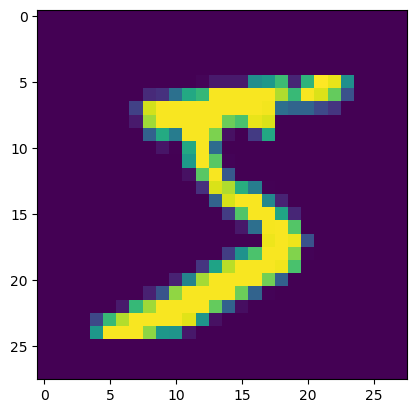

In [161]:
image0 = Xtrain[0, :]
image0 = image0.reshape(28, 28)
image0
plt.imshow(image0), Ttrain[0]

In [17]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Would you like to run on the GPU? (y or n): y
Running on cuda:0


In [88]:
len(np.unique(Ttrain))

10

In [31]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

adam: Epoch 2 Loss 0.498


KeyboardInterrupt: 

In [61]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table,
                                   index=class_names,
                                   columns=class_names)
    return conf_matrix

In [69]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 93.84


,0,1,2,3,4,5,6,7,8,9
0,94.285714,0.000000,0.918367,0.306122,0.102041,0.510204,2.551020,0.204082,0.306122,0.816327
1,0.000000,97.444934,0.528634,0.176211,0.088106,0.176211,0.176211,0.176211,1.233480,0.000000
2,0.872093,0.968992,93.023256,1.744186,0.484496,0.000000,0.290698,1.065891,1.550388,0.000000
3,0.099010,0.297030,1.584158,95.544554,0.000000,0.297030,0.000000,0.990099,0.594059,0.594059
4,0.000000,0.101833,1.120163,0.000000,94.501018,0.101833,1.731161,0.305499,0.407332,1.731161
5,0.448430,0.672646,0.112108,5.829596,0.000000,86.883408,1.457399,0.000000,3.026906,1.569507
6,0.626305,0.521921,0.104384,0.000000,0.208768,1.878914,96.555324,0.000000,0.104384,0.000000
7,0.000000,0.875486,2.431907,1.167315,0.486381,0.097276,0.000000,92.898833,0.097276,1.945525
8,0.205339,0.102669,0.718686,1.642710,0.205339,0.513347,0.513347,0.718686,94.455852,0.924025
9,0.495540,0.099108,0.495540,1.288404,3.270565,0.297324,0.000000,1.585728,0.693756,91.774034


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 2.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [62]:
from IPython.display import display, clear_output  # for the following animation.
import matplotlib.animation as animation
from pdb import set_trace
import time

def run_experiment(Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,
                   n_hidden_units_per_layer_choices,patch_size_per_conv_layer_choices,stride_per_conv_layer_choices,
                   n_hiddens_per_fc_layer_choices):
    n_epochs = 20
    batch_size = 500
    learning_rate = 0.01
    results = []
    Classes = np.unique(Ttrain)
    fig = plt.figure(figsize=(8, 8))
    val_graph = []
    #     Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X,T,n_folds)
    #         print(epoch)
    i = 0
    for i in range(len(n_hidden_units_per_layer_choices)):
        Time = []
        #             nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))

        #             nnet = NeuralNetworkClassifier(Xtrain.shape[1], hidden_units,len(Classes))
        n_hiddens_per_conv_layer = n_hidden_units_per_layer_choices[i]
        patch_size_per_conv_layer= patch_size_per_conv_layer_choices[i]
        stride_per_conv_layer = stride_per_conv_layer_choices[i]
        n_hiddens_per_fc_layer=n_hiddens_per_fc_layer_choices[i]
#         set_trace()
        cnnet = CNN2D(28 * 28,
                      n_hiddens_per_conv_layer,
                      n_hiddens_per_fc_layer,
                      len(np.unique(Ttrain)),
                      patch_size_per_conv_layer,
                      stride_per_conv_layer,
                      device=device)

        start_time = time.time()

        cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')


        Time_for_train = time.time() - start_time
        
        Classes, _ = cnnet.use(Xtest)
        perc_correct = 100 * np.mean(Classes == Ttest)

        C_test, Y_test = cnnet.use(Xtest)
        C_train, Y_train = cnnet.use(Xtrain)
        C_val, Y_val = cnnet.use(Xval)

        test_p = 100 * np.mean(C_test == Ttest)
        train_p = 100 * np.mean(C_train == Ttrain)
        val_p = 100 * np.mean(C_val == Tval)
                   
       
        val_graph.append(train_p)
        results.append([n_hiddens_per_conv_layer, train_p, val_p, test_p, Time_for_train])
        df = pandas.DataFrame(results,
                              columns=('nh', 'Train', 'Validate', 'Test',
                                       'Time'))
        fig.clf()

        # In second panel plot the weights versus the epoch number
        # plt.subplot(2, 2, i+1)
        # set_trace()
        xs = range(df.shape[0])
        plt.plot(xs, val_graph, 'o-')

        xticks = df[['nh']].apply(lambda x: f'{x[0]}',
                                  axis=1)  # converting to strings
        plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
        plt.xlabel('Epochs, Architecture')
        plt.xlim(0, len(n_hidden_units_per_layer_choices))
        plt.ylim(90, 100)
        plt.legend(('$Validation$', '$w_1$'))
        clear_output(wait=True)
        display(fig)

    return df

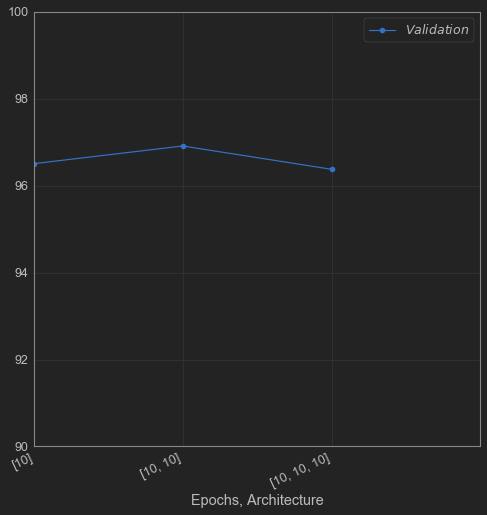

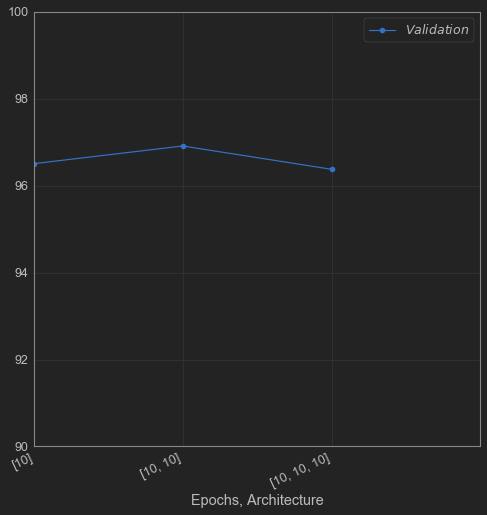

In [31]:
# n_hiddens_per_conv_layer = [10, 10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]


result_df = run_experiment( Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices=[[10],[10,10],[10,10,10]],
                           n_hiddens_per_fc_layer_choices=[[10],[10,10],[10,10,10]],
                          patch_size_per_conv_layer_choices = [[5],[5,5],[4,4,4]],
                          stride_per_conv_layer_choices=[[2],[2,2],[2,2,2]])



In [34]:
result_df

,nh,Train,Validate,Test,Time
0,[10],96.504,95.09,95.02,38.224590
1,"[10, 10]",96.910,96.31,95.91,45.450806
2,"[10, 10, 10]",96.374,95.58,95.53,49.978193


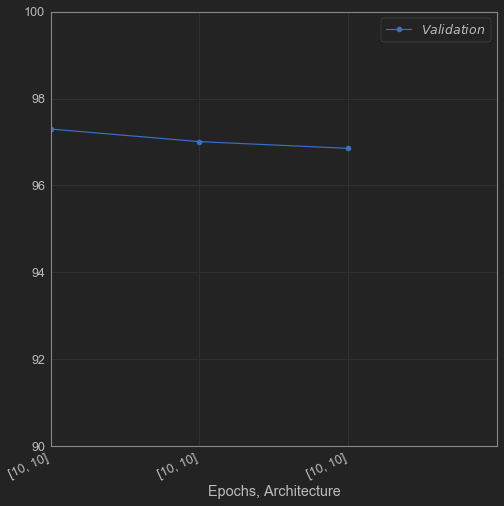

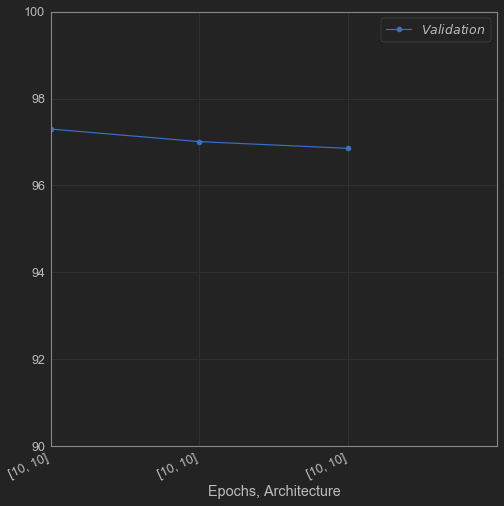

In [33]:
result_fc = run_experiment( Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices=[[10,10],[10,10],[10,10]],
                           n_hiddens_per_fc_layer_choices=[[10],[10],[10,10]],
                          patch_size_per_conv_layer_choices = [[5,5],[5,5],[5,5]],
                          stride_per_conv_layer_choices=[[2,2],[2,2],[2,2]])

In [13]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [5, 5]
stride_per_conv_layer=[2, 2]
n_hiddens_per_fc_layer = [10]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 2 Loss 0.231
adam: Epoch 4 Loss 0.143
adam: Epoch 6 Loss 0.120
adam: Epoch 8 Loss 0.101
adam: Epoch 10 Loss 0.103
adam: Epoch 12 Loss 0.095
adam: Epoch 14 Loss 0.094
adam: Epoch 16 Loss 0.089
adam: Epoch 18 Loss 0.084
adam: Epoch 20 Loss 0.083


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(10, 10, kernel_size=(5, 5), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=160, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
)

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `__init__` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately.
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [63]:
class CNN1D(CNN2D):
    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer,
                                n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer,
                                stride_per_conv_layer):

        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.

        n_in = 1
        input_hw = n_inputs  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0

        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(
                torch.nn.Conv1d(n_in,
                                nh,
                                kernel_size=patch_size,
                                stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <=0:
                raise Exception(
                    f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values, with zeros between the waves long.

In [64]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [271]:
make_square_pulse()

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

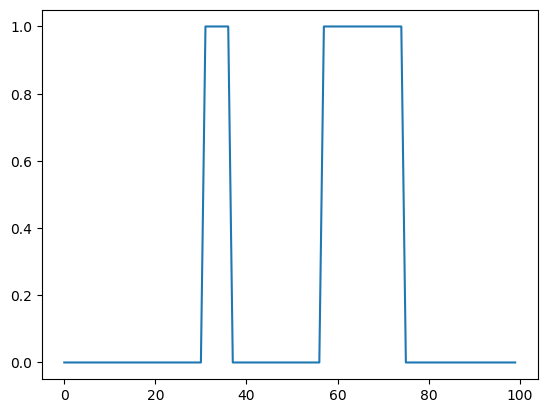

In [272]:
plt.plot(make_square_pulse());

In [65]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

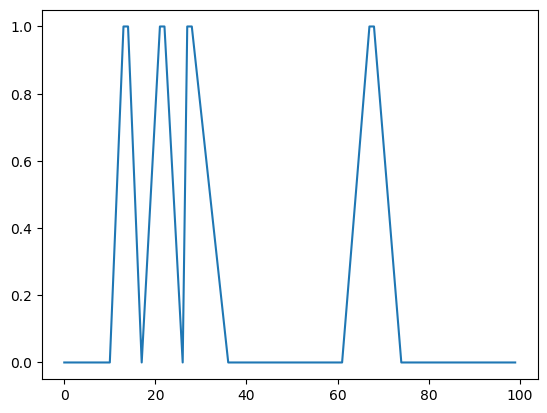

In [274]:
plt.plot(make_triangular_pulse());

In [275]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [276]:
np.newaxis == None

True

In [277]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [278]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtrain.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.607
adam: Epoch 20 Loss 0.509
adam: Epoch 30 Loss 0.178
adam: Epoch 40 Loss 0.056
adam: Epoch 50 Loss 0.016
adam: Epoch 60 Loss 0.007
adam: Epoch 70 Loss 0.005
adam: Epoch 80 Loss 0.013
adam: Epoch 90 Loss 0.007
adam: Epoch 100 Loss 0.001


Text(0.5, 1.0, 'Pulses')

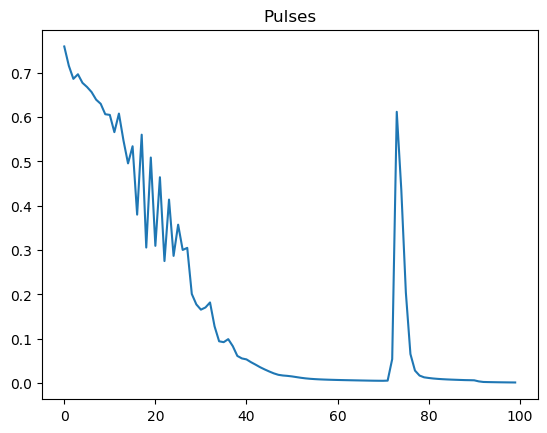

In [279]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [282]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 100.00


,square,triangular
square,100.0,0.0
triangular,0.0,100.0


torch.Size([10, 10])

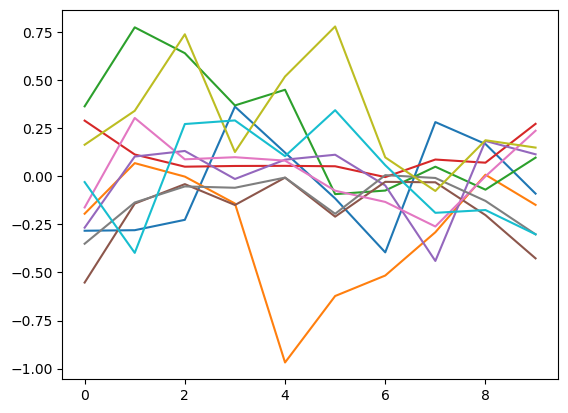

In [283]:

W = list(cnnet1.children())[0][0].weight.data.cpu()
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~anderson/cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [19]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

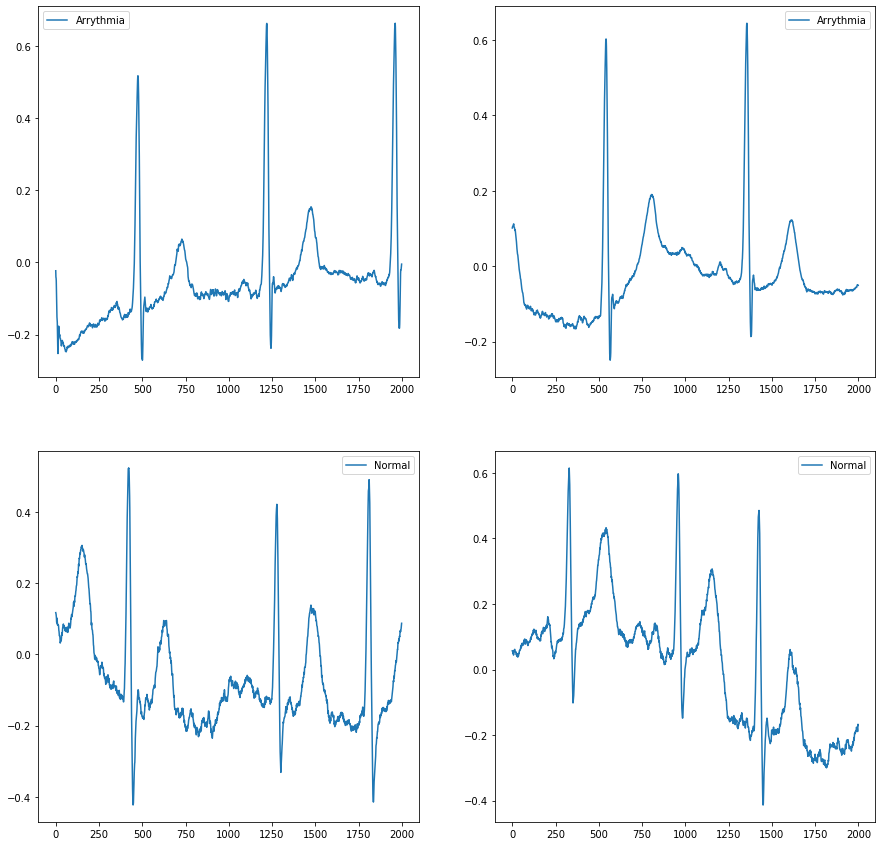

In [20]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [21]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [115]:
Xtrain.shape,Ttrain.shape
device

device(type='cuda', index=0)

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [300]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [10, 1], [20, 5], device=device)
cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')


adam: Epoch 10 Loss 0.629
adam: Epoch 20 Loss 0.561
adam: Epoch 30 Loss 0.501
adam: Epoch 40 Loss 0.457
adam: Epoch 50 Loss 0.427
adam: Epoch 60 Loss 0.400
adam: Epoch 70 Loss 0.378
adam: Epoch 80 Loss 0.358
adam: Epoch 90 Loss 0.340
adam: Epoch 100 Loss 0.324


CNN1D(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 5, kernel_size=(10,), stride=(20,))
    (1): Conv1d(5, 10, kernel_size=(1,), stride=(5,))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=200, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [66]:
from IPython.display import display, clear_output  # for the following animation.
import matplotlib.animation as animation
from pdb import set_trace
import time

def run_experiment_1d(Xtrain, Ttrain, Xtest, Ttest,
                   n_hidden_units_per_layer_choices,patch_size_per_conv_layer_choices,stride_per_conv_layer_choices,
                   n_hiddens_per_fc_layer_choices):
    n_epochs = 100
    batch_size = 10
    learning_rate = 0.001
    results = []
    Classes = np.unique(Ttrain)
    fig = plt.figure(figsize=(8, 8))
    train_graph = []
    #     Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X,T,n_folds)
    #         print(epoch)
    i = 0
    for i in range(len(n_hidden_units_per_layer_choices)):
        Time = []
        #             nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))

        #             nnet = NeuralNetworkClassifier(Xtrain.shape[1], hidden_units,len(Classes))
        n_hiddens_per_conv_layer = n_hidden_units_per_layer_choices[i]
        patch_size_per_conv_layer= patch_size_per_conv_layer_choices[i]
        stride_per_conv_layer = stride_per_conv_layer_choices[i]
        n_hiddens_per_fc_layer=n_hiddens_per_fc_layer_choices[i]
#         set_trace()
# cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [10, 1], [20, 5], device=device)

        cnnet = CNN1D(Xtrain.shape[-1],
                      n_hiddens_per_conv_layer,
                      n_hiddens_per_fc_layer,
                      len(np.unique(Ttrain)),
                      patch_size_per_conv_layer,
                      stride_per_conv_layer,
                      device=device)

        start_time = time.time()

        cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')


        Time_for_train = time.time() - start_time
        
        Classes, _ = cnnet.use(Xtest)
        perc_correct = 100 * np.mean(Classes == Ttest)

        C_test, Y_test = cnnet.use(Xtest)
        C_train, Y_train = cnnet.use(Xtrain)
#         C_val, Y_val = cnnet.use(Xval)

        test_p = 100 * np.mean(C_test == Ttest)
        train_p = 100 * np.mean(C_train == Ttrain)
#         val_p = 100 * np.mean(C_val == Tval)
                   
       
        train_graph.append(test_p)
        results.append([n_hiddens_per_conv_layer,
                        n_hiddens_per_fc_layer,
                        patch_size_per_conv_layer,
                        stride_per_conv_layer,
                        train_p,
                        test_p, 
                        Time_for_train])
        df = pandas.DataFrame(results,
                              columns=('nh','fc','patch','stride', 'Train', 'Test', 'Time'))
        fig.clf()

        # In second panel plot the weights versus the epoch number
        # plt.subplot(2, 2, i+1)
        # set_trace()
        xs = range(df.shape[0])
        plt.plot(xs, train_graph, 'o-')

        xticks = df[['nh','fc','patch','stride']].apply(lambda x: f'{x[0]}',
                                  axis=1)  # converting to strings
        plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
        plt.xlabel('Epochs, Architecture')
        plt.xlim(0, len(n_hidden_units_per_layer_choices))
        plt.ylim(60, 100)
        plt.legend(('$Testing$', '$w_1$'))
        clear_output(wait=True)
        display(fig)

    return df

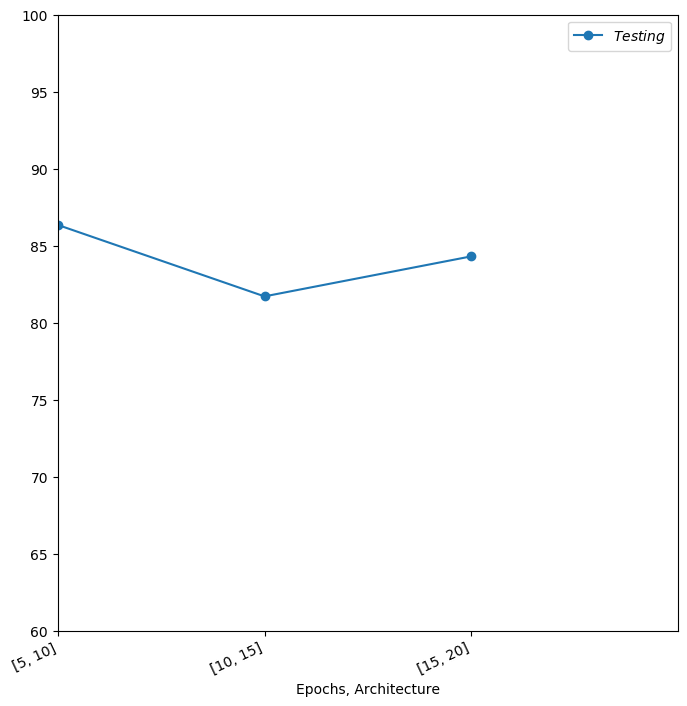

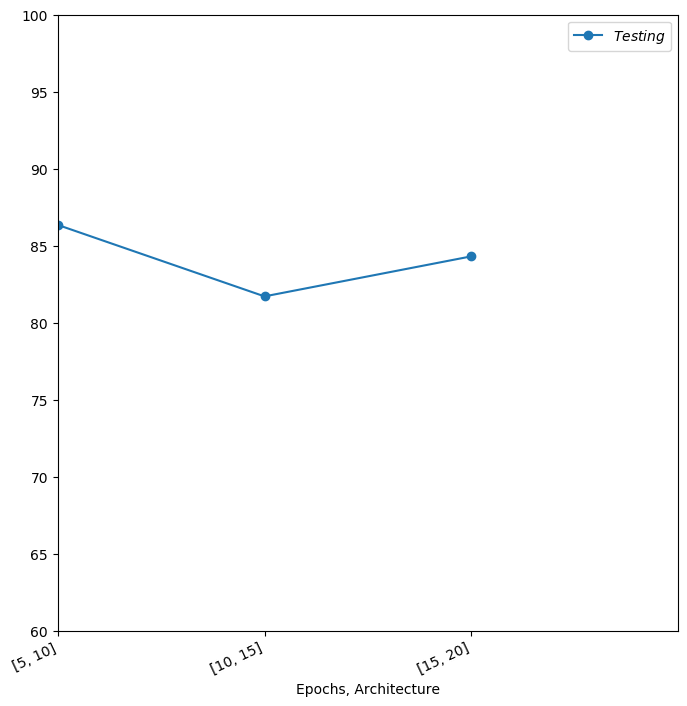

In [302]:
# cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [10, 1], [20, 5], device=device)

#         cnnet = CNN1D(Xtrain.shape[-1],
#                       n_hiddens_per_conv_layer,
#                       n_hiddens_per_fc_layer,
#                       len(np.unique(Ttrain)),
#                       patch_size_per_conv_layer,
#                       stride_per_conv_layer,
#                       device=device)
result_1d = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[10,15],[15,20]], #,[5,10,15],[5,10,15,20],[15,20],[5,10],[10,15],[15,20]],
                           n_hiddens_per_fc_layer_choices   =[[10,10],[10,10],[10,10]],#,[10,10],[10],[10,10]],
                          patch_size_per_conv_layer_choices =[[10,1],[10,1],[10,1]], #[10,10],[10],[10,10]],
                          stride_per_conv_layer_choices     =[[20,5],[20,5],[20,5]]) # [10,10],[10],[10,10]])

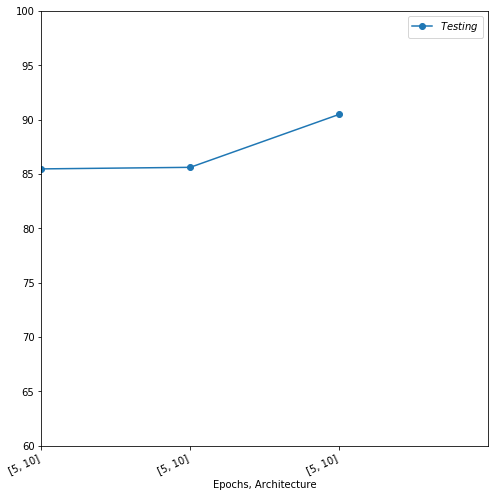

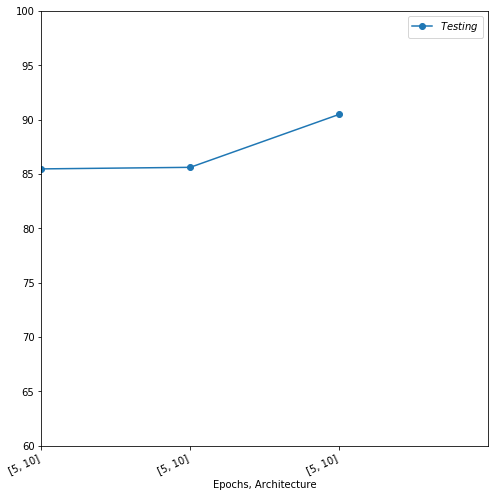

In [22]:
result_1d_1 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], #,[5,10,15],[5,10,15,20],[15,20],[5,10],[10,15],[15,20]],
                           n_hiddens_per_fc_layer_choices   =[[10,10],[10,10],[10,10]],#,[10,10],[10],[10,10]],
                          patch_size_per_conv_layer_choices =[[20,1],[40,1],[80,1]], #[10,10],[10],[10,10]],
                          stride_per_conv_layer_choices     =[[20,5],[20,5],[20,5]]) # [10,10],[10],[10,10]])

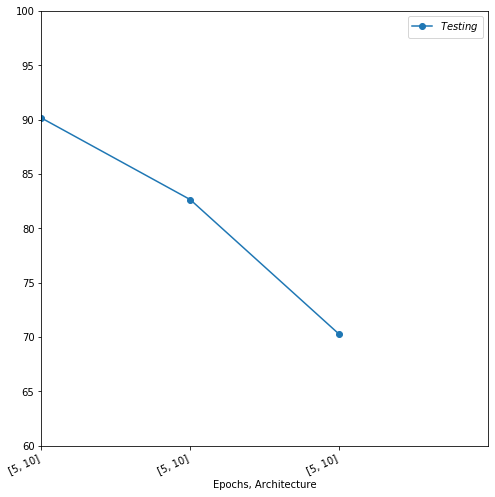

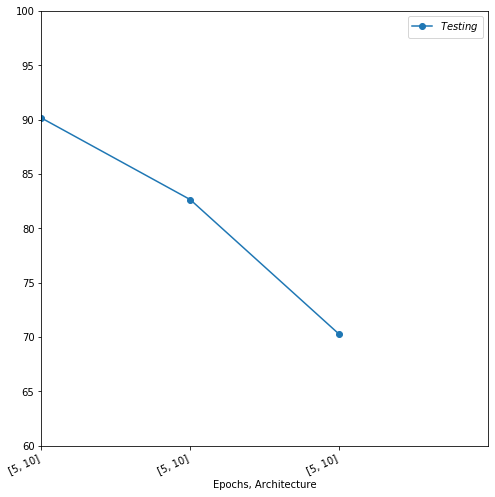

In [23]:
result_1d_2 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], #,[5,10,15],[5,10,15,20],[15,20],[5,10],[10,15],[15,20]],
                           n_hiddens_per_fc_layer_choices   =[[10,10],[10,10],[10,10]],#,[10,10],[10],[10,10]],
                          patch_size_per_conv_layer_choices =[[80,1],[80,1],[80,1]], #[10,10],[10],[10,10]],
                          stride_per_conv_layer_choices     =[[10,5],[20,10],[40,20]]) # [10,10],[10],[10,10]])

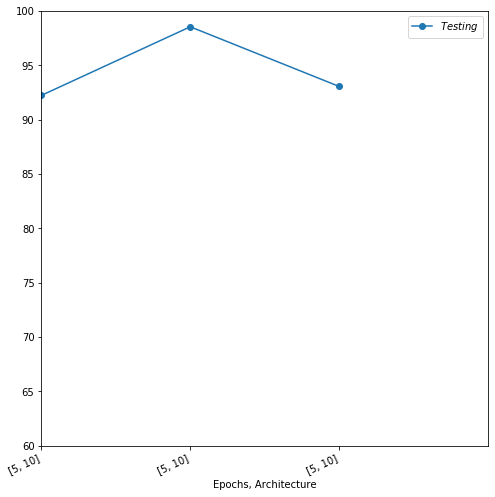

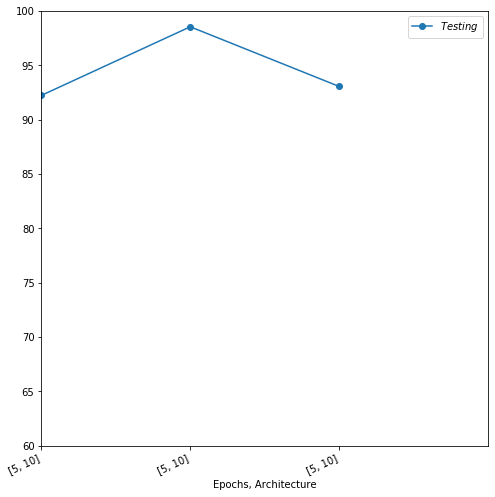

In [25]:
result_1d_3 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], 
                           n_hiddens_per_fc_layer_choices   =[[10,10],[10,10],[10,10]],
                          patch_size_per_conv_layer_choices =[[80,1],[80,1],[80,1]], 
                          stride_per_conv_layer_choices     =[[5,5],[4,4],[3,3]]) 

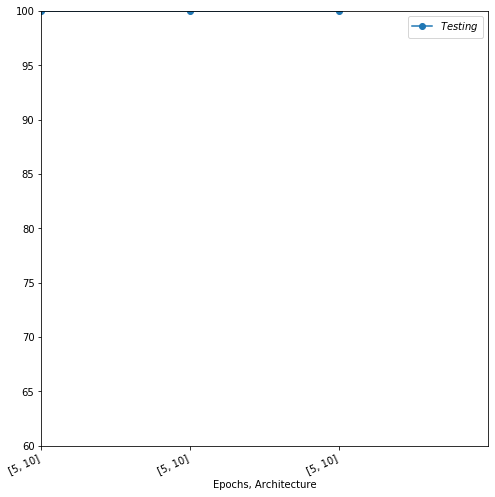

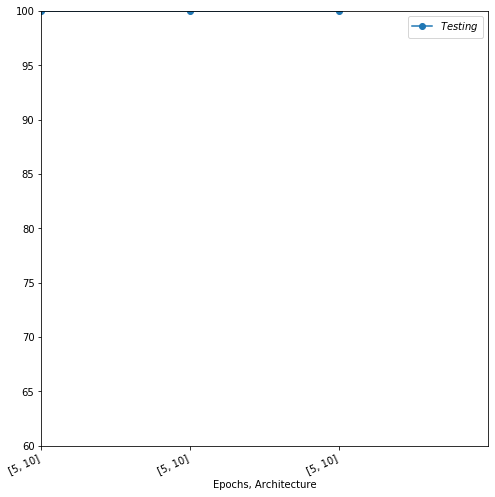

In [30]:
result_1d_4 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], 
                           n_hiddens_per_fc_layer_choices   =[[600,300],[300,150],[200,100]],
                          patch_size_per_conv_layer_choices =[[80,1],[80,1],[80,1]], 
                          stride_per_conv_layer_choices     =[[4,4],[4,4],[4,4]])

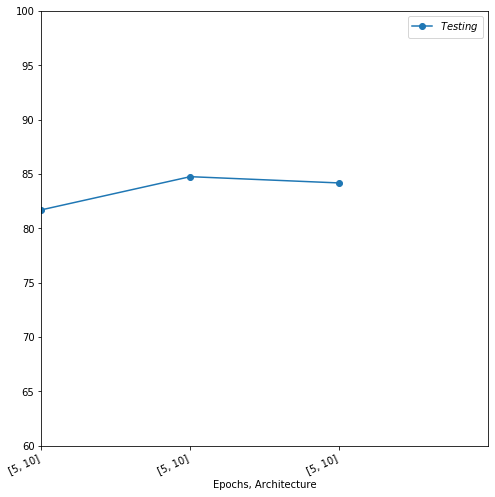

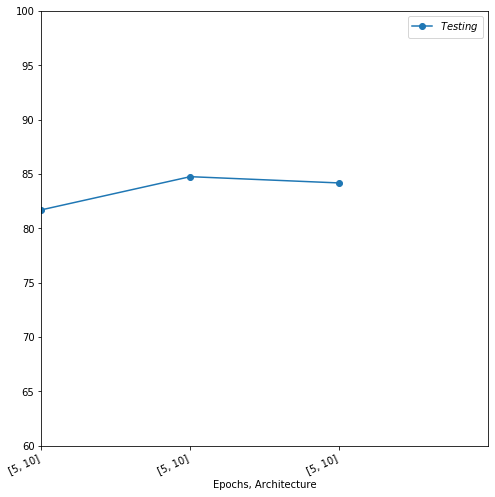

In [54]:
result_1d_5 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]],
                           n_hiddens_per_fc_layer_choices   =[[600,300],[600,300],[600,300]],
                          patch_size_per_conv_layer_choices =[[100,1],[150,1],[200,1]],
                          stride_per_conv_layer_choices     =[[4,4],[4,4],[4,4]])

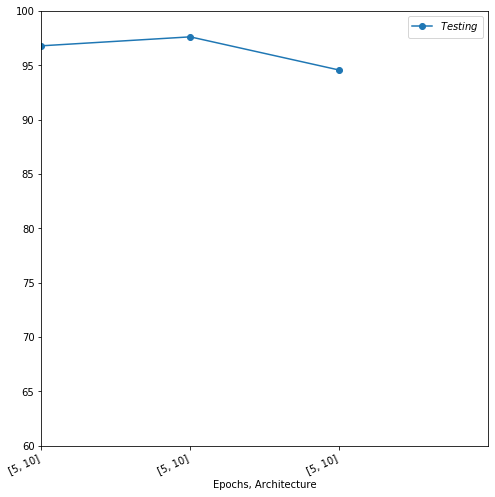

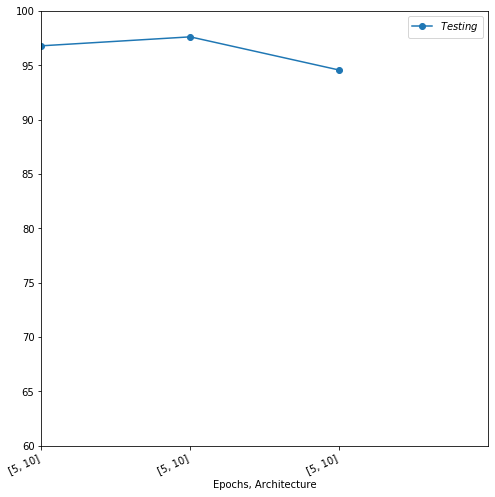

In [56]:
result_1d_6 = run_experiment_1d( Xtrain, Ttrain, Xtest, Ttest,                          
                           n_hidden_units_per_layer_choices =[[5,10],[5,10],[5,10]], #,[5,10,15],[5,10,15,20],[15,20],[5,10],[10,15],[15,20]],
                           n_hiddens_per_fc_layer_choices   =[[600,300],[600,300],[600,300]],#,[10,10],[10],[10,10]],
                          patch_size_per_conv_layer_choices =[[150,50],[150,75],[150,100]], #[10,10],[10],[10,10]],
                          stride_per_conv_layer_choices     =[[4,4],[4,4],[4,4]]) # [10,10],[10],[10,10]])

In [108]:
final = pandas.DataFrame()
final = final.append(result_1d_1, ignore_index=True)
final = final.append(result_1d_2, ignore_index=True)
final = final.append(result_1d_3, ignore_index=True)
final = final.append(result_1d_4, ignore_index=True)
final = final.append(result_1d_5, ignore_index=True)
final = final.append(result_1d_6, ignore_index=True)

final

,nh,fc,patch,stride,Train,Test,Time
0,"[5, 10]","[10, 10]","[20, 1]","[20, 5]",85.463918,65.210223,304.519978
1,"[5, 10]","[10, 10]","[40, 1]","[20, 5]",85.608247,68.260511,307.604056
2,"[5, 10]","[10, 10]","[80, 1]","[20, 5]",90.474227,72.712284,305.072100
3,"[5, 10]","[10, 10]","[80, 1]","[10, 5]",90.144330,67.023908,313.822925
4,"[5, 10]","[10, 10]","[80, 1]","[20, 10]",82.639175,72.794724,316.126693
5,"[5, 10]","[10, 10]","[80, 1]","[40, 20]",70.268041,62.819456,313.883940
6,"[5, 10]","[10, 10]","[80, 1]","[5, 5]",92.226804,69.744435,329.964319
7,"[5, 10]","[10, 10]","[80, 1]","[4, 4]",98.536082,71.723001,349.294620
8,"[5, 10]","[10, 10]","[80, 1]","[3, 3]",93.051546,70.651278,362.784013
9,"[5, 10]","[600, 300]","[80, 1]","[4, 4]",100.000000,77.411377,379.390219


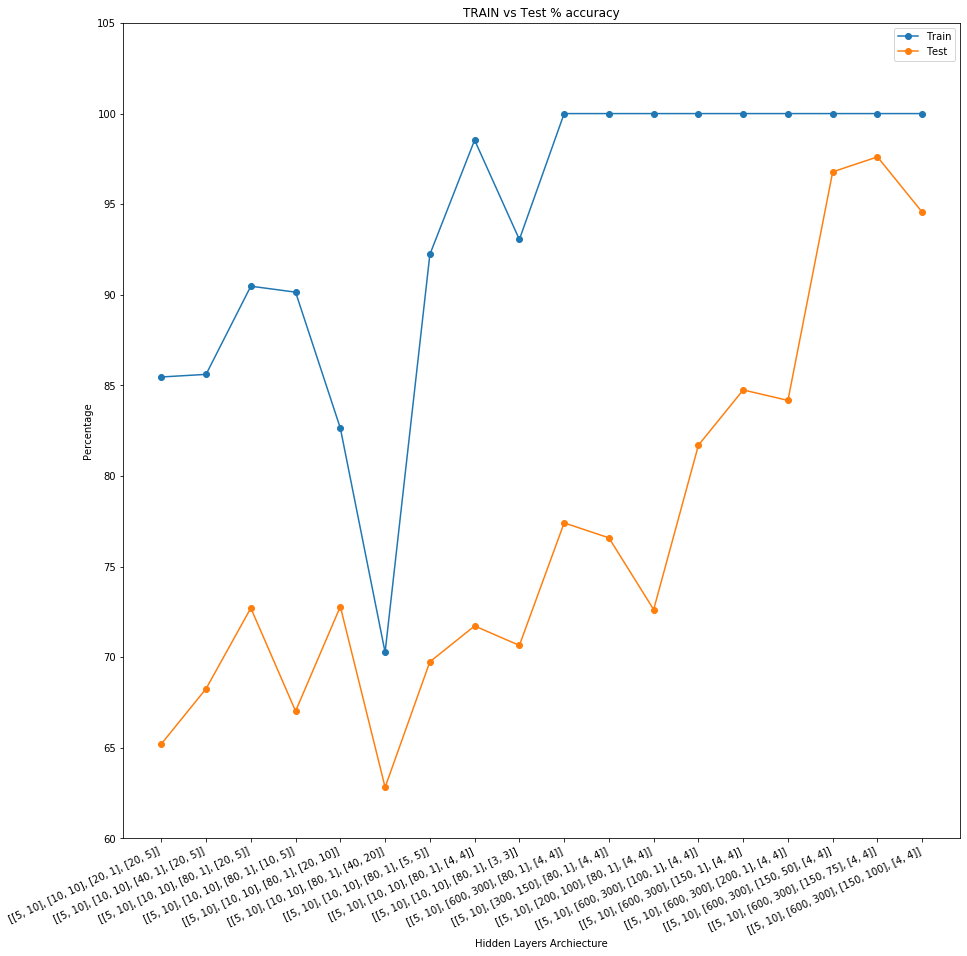

In [109]:
X_axis = final.loc[:, 'Train']
X_axis1 = final.loc[:, 'Test']
plt.figure(figsize=(15, 15))
plt.plot(X_axis, 'o-', label='Train')
plt.plot(X_axis1, 'o-', label='Test')
xticks = final[['nh','fc','patch','stride']].apply(lambda x: f'{[x[0]] + [x[1]] + [x[2]] +[x[3]]}', axis=1)
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.ylim(60, 105)
plt.xlabel('Hidden Layers Archiecture')
plt.ylabel('Percentage');
plt.title('TRAIN vs Test Accuracy')
plt.legend()



In [116]:
final.to_pickle("./data.pkl")

In [111]:
n_epochs = 100
batch_size = 10
learning_rate = 0.001
cnn1d_best = CNN1D(Xtrain.shape[-1], [5, 10], [600, 300], 2, [150, 75], [4, 4], device=device)
cnn1d_best.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

adam: Epoch 10 Loss 0.090
adam: Epoch 20 Loss 0.016
adam: Epoch 30 Loss 0.000
adam: Epoch 40 Loss 0.000
adam: Epoch 50 Loss 0.000
adam: Epoch 60 Loss 0.000
adam: Epoch 70 Loss 0.000
adam: Epoch 80 Loss 0.000
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


CNN1D(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 5, kernel_size=(150,), stride=(4,))
    (1): Conv1d(5, 10, kernel_size=(75,), stride=(4,))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=980, out_features=600, bias=True)
    (1): Linear(in_features=600, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=2, bias=True)
  )
)

In [113]:
Classes, _ = cnn1d_best.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 96.37


,arr,nr
arr,92.885375,7.114625
nr,1.131542,98.868458


# Observartions

Initially I have tried to increase the patch sizes and we have observed an increase in the performance of the model yet the model couldnt cross 90% in the training accuracy and just reached 72% in testing data accuracy. with the best value obtained from the patch Size i.e. [80,1] the stride values were gradually increase and observed that there was a significant drop in the accuracy of the model. So it was evident that with large strides we were skipping more data while training and this is adversly effecting the performance. Hence I tried to reduce the stride values in next consequitives iterations and observed that there was an improvement in the performance of model. I observed that with patch size of [80,1] and stride of [4,4] the model was performing better than remaining configurations.

Now with this patch size and stride values kept constant, The fully connected layers were increased and it was observed that the model was performing better and we were able to attain 100% accuracy on the train data but still the performance on the test data couldnt reach 80%. The model was able to reach 100 accuracy on the training data for a fully connected layer  configuration of [600,300]. With this kept constant for the rest of the experiment the patch sizes were signifacntly increase again and I could observe that the model was performing better on the training data and was able to reach an accuracy of 97.60% for the following configuration:
 
hidden Layers = [5, 10]
fully connected layer :[600, 300]
Patch Size = [150, 75] 
Stride = [4, 4]


Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [119]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Gannavarapu-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(c

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.

In [197]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)
Xval = Xval.reshape(-1, 1, 28, 28)


# 1 Tanh vs Relu

In [198]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]
n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet_tanh = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh',device=device)




cnnet_relu = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function='relu',device=device)



cnnet_tanh.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet_relu.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')


adam: Epoch 2 Loss 0.501
adam: Epoch 4 Loss 0.299
adam: Epoch 6 Loss 0.246
adam: Epoch 8 Loss 0.218
adam: Epoch 10 Loss 0.198
adam: Epoch 12 Loss 0.191
adam: Epoch 14 Loss 0.177
adam: Epoch 16 Loss 0.172
adam: Epoch 18 Loss 0.169
adam: Epoch 20 Loss 0.159
adam: Epoch 2 Loss 0.249
adam: Epoch 4 Loss 0.141
adam: Epoch 6 Loss 0.112
adam: Epoch 8 Loss 0.099
adam: Epoch 10 Loss 0.092
adam: Epoch 12 Loss 0.081
adam: Epoch 14 Loss 0.077
adam: Epoch 16 Loss 0.073
adam: Epoch 18 Loss 0.073
adam: Epoch 20 Loss 0.069


CNN2D(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(10, 10), stride=(4, 4))
    (1): Conv2d(10, 10, kernel_size=(5, 5), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=10, bias=True)
  )
)

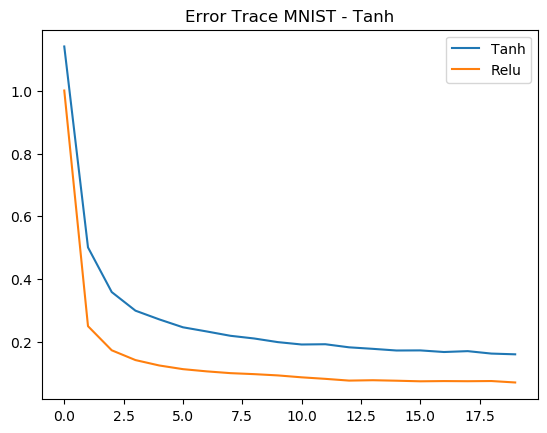

In [199]:

plt.plot(cnnet_tanh.error_trace, label='Tanh')
plt.title('MNIST - Relu')

plt.plot(cnnet_relu.error_trace, label='Relu')
plt.title('Error Trace MNIST - Tanh')
plt.legend(loc='best') 


In [207]:
Classes, _ = cnnet_tanh.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct with Tanh Activation function: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest).style.background_gradient(cmap='Greens').format("{:.1f} %")


Test accuracy in percent correct with Tanh Activation function: 94.24


,0,1,2,3,4,5,6,7,8,9
0,95.9 %,0.3 %,0.7 %,0.0 %,0.0 %,1.0 %,1.4 %,0.5 %,0.1 %,0.0 %
1,0.1 %,97.9 %,0.6 %,0.1 %,0.0 %,0.4 %,0.1 %,0.4 %,0.4 %,0.0 %
2,0.6 %,0.9 %,94.6 %,0.6 %,0.2 %,0.0 %,0.5 %,1.6 %,1.1 %,0.1 %
3,0.0 %,0.2 %,0.5 %,94.7 %,0.1 %,1.0 %,0.1 %,1.2 %,2.3 %,0.0 %
4,0.3 %,0.2 %,0.2 %,0.1 %,95.6 %,0.0 %,1.0 %,0.4 %,0.5 %,1.6 %
5,0.4 %,0.1 %,0.2 %,2.8 %,0.4 %,91.9 %,2.0 %,0.0 %,2.0 %,0.0 %
6,1.6 %,0.2 %,0.4 %,0.1 %,1.4 %,0.8 %,95.4 %,0.0 %,0.1 %,0.0 %
7,0.0 %,0.9 %,1.4 %,0.8 %,0.0 %,0.1 %,0.0 %,95.7 %,0.4 %,0.8 %
8,0.2 %,0.6 %,2.2 %,2.4 %,0.8 %,1.5 %,0.4 %,0.4 %,90.6 %,0.9 %
9,0.4 %,0.5 %,0.1 %,0.8 %,3.7 %,0.6 %,0.5 %,2.5 %,1.6 %,89.4 %


In [203]:
Classes, _ = cnnet_relu.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct with Relu Acttivation function : {perc_correct:.2f}')
confusion_matrix(Classes, Ttest).style.background_gradient(cmap='Greens').format("{:.1f} %")


Test accuracy in percent correct with Relu Acttivation function : 96.77


,0,1,2,3,4,5,6,7,8,9
0,97.0 %,0.0 %,0.7 %,0.1 %,0.0 %,0.1 %,1.9 %,0.1 %,0.0 %,0.0 %
1,0.0 %,98.6 %,0.2 %,0.2 %,0.0 %,0.0 %,0.0 %,0.4 %,0.6 %,0.0 %
2,0.2 %,0.8 %,96.7 %,1.3 %,0.1 %,0.0 %,0.1 %,0.8 %,0.1 %,0.0 %
3,0.0 %,0.0 %,0.5 %,98.9 %,0.1 %,0.1 %,0.0 %,0.2 %,0.2 %,0.0 %
4,0.0 %,0.2 %,0.4 %,0.0 %,97.6 %,0.0 %,0.3 %,0.6 %,0.0 %,0.9 %
5,0.1 %,0.0 %,0.1 %,1.8 %,0.0 %,96.0 %,0.8 %,0.3 %,0.7 %,0.2 %
6,0.2 %,0.1 %,0.1 %,0.0 %,0.6 %,0.3 %,98.4 %,0.0 %,0.2 %,0.0 %
7,0.0 %,0.1 %,1.1 %,0.6 %,0.2 %,0.1 %,0.0 %,97.6 %,0.0 %,0.4 %
8,0.6 %,0.1 %,0.6 %,3.0 %,0.8 %,0.5 %,1.3 %,0.9 %,91.4 %,0.7 %
9,0.1 %,0.2 %,0.0 %,0.8 %,2.1 %,0.3 %,0.0 %,1.2 %,0.2 %,95.1 %


## Observations:

Between Tanh and Relu Activation functions Relu had performed better. It was able to acheive a Testing accuracy of 96.77%. It can also be seen from the error trace that Relu was able to reach minimum value faster than compared to Tanh That means the model was trained faster thatn Tanh. We can also observe from the confusion matrix that Relu activation function was able to predict numbers better compared to Tanh. Also the model with Relu activaiton funciton was able to reduce the number of false positives. for instance the number 9 was predicted 7 2.5% times in Tanh whereas Relu just had 1.2%  of them miss predicted. 


# 2 ADAM vs SGD

adam: Epoch 2 Loss 0.439
adam: Epoch 4 Loss 0.287
adam: Epoch 6 Loss 0.242
adam: Epoch 8 Loss 0.218
adam: Epoch 10 Loss 0.198
adam: Epoch 12 Loss 0.187
adam: Epoch 14 Loss 0.178
adam: Epoch 16 Loss 0.164
adam: Epoch 18 Loss 0.157
adam: Epoch 20 Loss 0.157
sgd: Epoch 2 Loss 1.222
sgd: Epoch 4 Loss 0.695
sgd: Epoch 6 Loss 0.500
sgd: Epoch 8 Loss 0.377
sgd: Epoch 10 Loss 0.305
sgd: Epoch 12 Loss 0.262
sgd: Epoch 14 Loss 0.233
sgd: Epoch 16 Loss 0.211
sgd: Epoch 18 Loss 0.195
sgd: Epoch 20 Loss 0.182
Test accuracy in percent correct for adam: 94.66
Test accuracy in percent correct for sgd: 94.56


,0,1,2,3,4,5,6,7,8,9
0,98.673469,0.000000,0.204082,0.204082,0.000000,0.102041,0.612245,0.102041,0.102041,0.000000
1,0.000000,97.973568,0.352423,0.176211,0.000000,0.176211,0.088106,0.000000,1.145374,0.088106
2,1.065891,0.193798,95.348837,1.162791,0.000000,0.000000,0.387597,1.259690,0.484496,0.096899
3,0.000000,0.594059,1.782178,94.455446,0.099010,1.089109,0.198020,1.188119,0.594059,0.000000
4,0.203666,0.000000,0.203666,0.101833,93.991853,0.101833,1.323829,0.509165,0.101833,3.462322
5,0.784753,0.112108,0.000000,3.811659,0.448430,91.928251,1.233184,0.000000,1.457399,0.224215
6,0.730689,0.208768,0.000000,0.521921,0.730689,0.521921,96.450939,0.000000,0.835073,0.000000
7,0.097276,1.361868,1.167315,0.778210,0.389105,0.097276,0.000000,94.455253,0.000000,1.653696
8,0.821355,0.616016,1.950719,0.616016,0.410678,2.566735,1.334702,0.513347,89.219713,1.950719
9,0.396432,0.495540,0.198216,0.495540,2.874133,1.387512,0.000000,0.991080,0.792864,92.368682


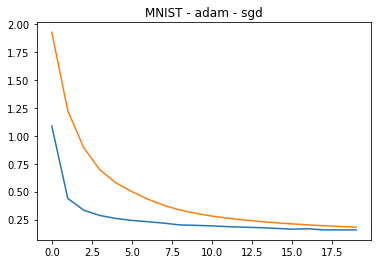

In [20]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]
n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet_adam = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh',device=device)




cnnet_sgd = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh',device=device)



cnnet_adam.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet_sgd.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='sgd')


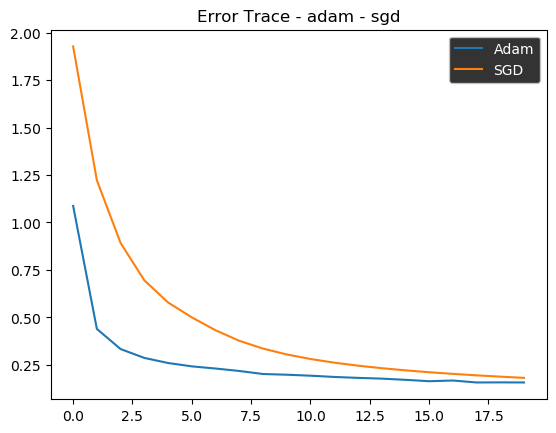

In [130]:
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided

#jtplot.style()
jtplot.reset()

plt.plot(cnnet_adam.error_trace, label='Adam')
plt.title('MNIST - adam - sgd')


plt.style.use('dark_background')

plt.plot(cnnet_sgd.error_trace, label='SGD')
plt.title('Error Trace - adam - sgd')
plt.legend(loc='best') 



In [42]:

Classes, _ = cnnet_adam.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct for adam: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest).style.background_gradient(cmap='Greens').format("{:.1f} %")


Test accuracy in percent correct for adam: 94.66


,0,1,2,3,4,5,6,7,8,9
0,97.0 %,0.0 %,0.4 %,0.0 %,0.1 %,0.3 %,0.6 %,0.5 %,1.0 %,0.0 %
1,0.0 %,98.1 %,0.4 %,0.4 %,0.1 %,0.1 %,0.4 %,0.2 %,0.4 %,0.0 %
2,0.3 %,0.5 %,95.0 %,1.6 %,0.0 %,0.0 %,0.6 %,0.9 %,1.2 %,0.0 %
3,0.1 %,0.3 %,1.9 %,94.8 %,0.0 %,0.3 %,0.0 %,0.7 %,1.3 %,0.7 %
4,0.2 %,0.5 %,0.0 %,0.2 %,95.2 %,0.0 %,1.0 %,0.2 %,0.2 %,2.4 %
5,0.9 %,0.6 %,0.1 %,3.7 %,0.7 %,90.9 %,0.6 %,0.2 %,1.1 %,1.2 %
6,0.9 %,0.1 %,0.2 %,0.0 %,1.1 %,0.3 %,96.1 %,0.2 %,0.8 %,0.1 %
7,0.0 %,0.7 %,2.6 %,1.0 %,0.7 %,0.0 %,0.0 %,94.3 %,0.0 %,0.8 %
8,0.7 %,0.2 %,1.7 %,1.6 %,0.5 %,0.6 %,1.3 %,0.2 %,92.2 %,0.8 %
9,0.3 %,0.3 %,0.3 %,1.0 %,1.9 %,0.5 %,0.1 %,2.4 %,1.1 %,92.2 %


In [43]:
Classes1, _ = cnnet_sgd.use(Xtest)
perc_correct = 100 * np.mean(Classes1 == Ttest)
print(f'Test accuracy in percent correct for sgd: {perc_correct:.2f}')
confusion_matrix(Classes1, Ttest).style.background_gradient(cmap='Greens').format("{:.1f} %")

Test accuracy in percent correct for sgd: 94.56


,0,1,2,3,4,5,6,7,8,9
0,98.7 %,0.0 %,0.2 %,0.2 %,0.0 %,0.1 %,0.6 %,0.1 %,0.1 %,0.0 %
1,0.0 %,98.0 %,0.4 %,0.2 %,0.0 %,0.2 %,0.1 %,0.0 %,1.1 %,0.1 %
2,1.1 %,0.2 %,95.3 %,1.2 %,0.0 %,0.0 %,0.4 %,1.3 %,0.5 %,0.1 %
3,0.0 %,0.6 %,1.8 %,94.5 %,0.1 %,1.1 %,0.2 %,1.2 %,0.6 %,0.0 %
4,0.2 %,0.0 %,0.2 %,0.1 %,94.0 %,0.1 %,1.3 %,0.5 %,0.1 %,3.5 %
5,0.8 %,0.1 %,0.0 %,3.8 %,0.4 %,91.9 %,1.2 %,0.0 %,1.5 %,0.2 %
6,0.7 %,0.2 %,0.0 %,0.5 %,0.7 %,0.5 %,96.5 %,0.0 %,0.8 %,0.0 %
7,0.1 %,1.4 %,1.2 %,0.8 %,0.4 %,0.1 %,0.0 %,94.5 %,0.0 %,1.7 %
8,0.8 %,0.6 %,2.0 %,0.6 %,0.4 %,2.6 %,1.3 %,0.5 %,89.2 %,2.0 %
9,0.4 %,0.5 %,0.2 %,0.5 %,2.9 %,1.4 %,0.0 %,1.0 %,0.8 %,92.4 %


## Observations:


We can clearly see from the error trace that Adam had outperformed SGD and also the model could reach low error faster compared to SGD. This also means that the model with ADAM method trained faster. Howeve the error value reached by both mehtods was almost same after some point but Adam was able to reach faster.

Although there isnt a significant differenc in the Testing accuracies of both Adam and SGD

# 3 MNIST Fashion dataset

In [117]:
import pickle
import gzip

import os
import gzip
import numpy as np

# images = gzip.open("train-images-idx3-ubyte.gz", 'rb')
# X_train, y_train = load_mnist(pwd)
# X_test, y_test = load_mnist(pwd)
with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as lbpath:
    Ttrain = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as imgpath:
    Xtrain = np.frombuffer(imgpath.read(), dtype=np.uint8,
                            offset=16).reshape(len(Ttrain), 784)
    
with gzip.open('t10k-labels-idx1-ubyte.gz', 'rb') as lbpath:
    Ttest = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
with gzip.open('t10k-images-idx3-ubyte.gz', 'rb') as imgpath:
    Xtest = np.frombuffer(imgpath.read(), dtype=np.uint8,
                            offset=16).reshape(len(Ttest), 784)
labels={
    0: 't_shirt',
    1: 'trouser',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneaker',
    8: 'bag',
    9: 'ankle_boots'}
Ttrain=Ttrain.reshape(-1, 1)
Ttest=Ttest.reshape(-1, 1)
Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)


In [164]:

np.shape(Xtrain),np.shape(Ttrain),np.shape(Xtest),np.shape(Ttest)


((60000, 1, 28, 28), (60000, 1), (10000, 1, 28, 28), (10000, 1))

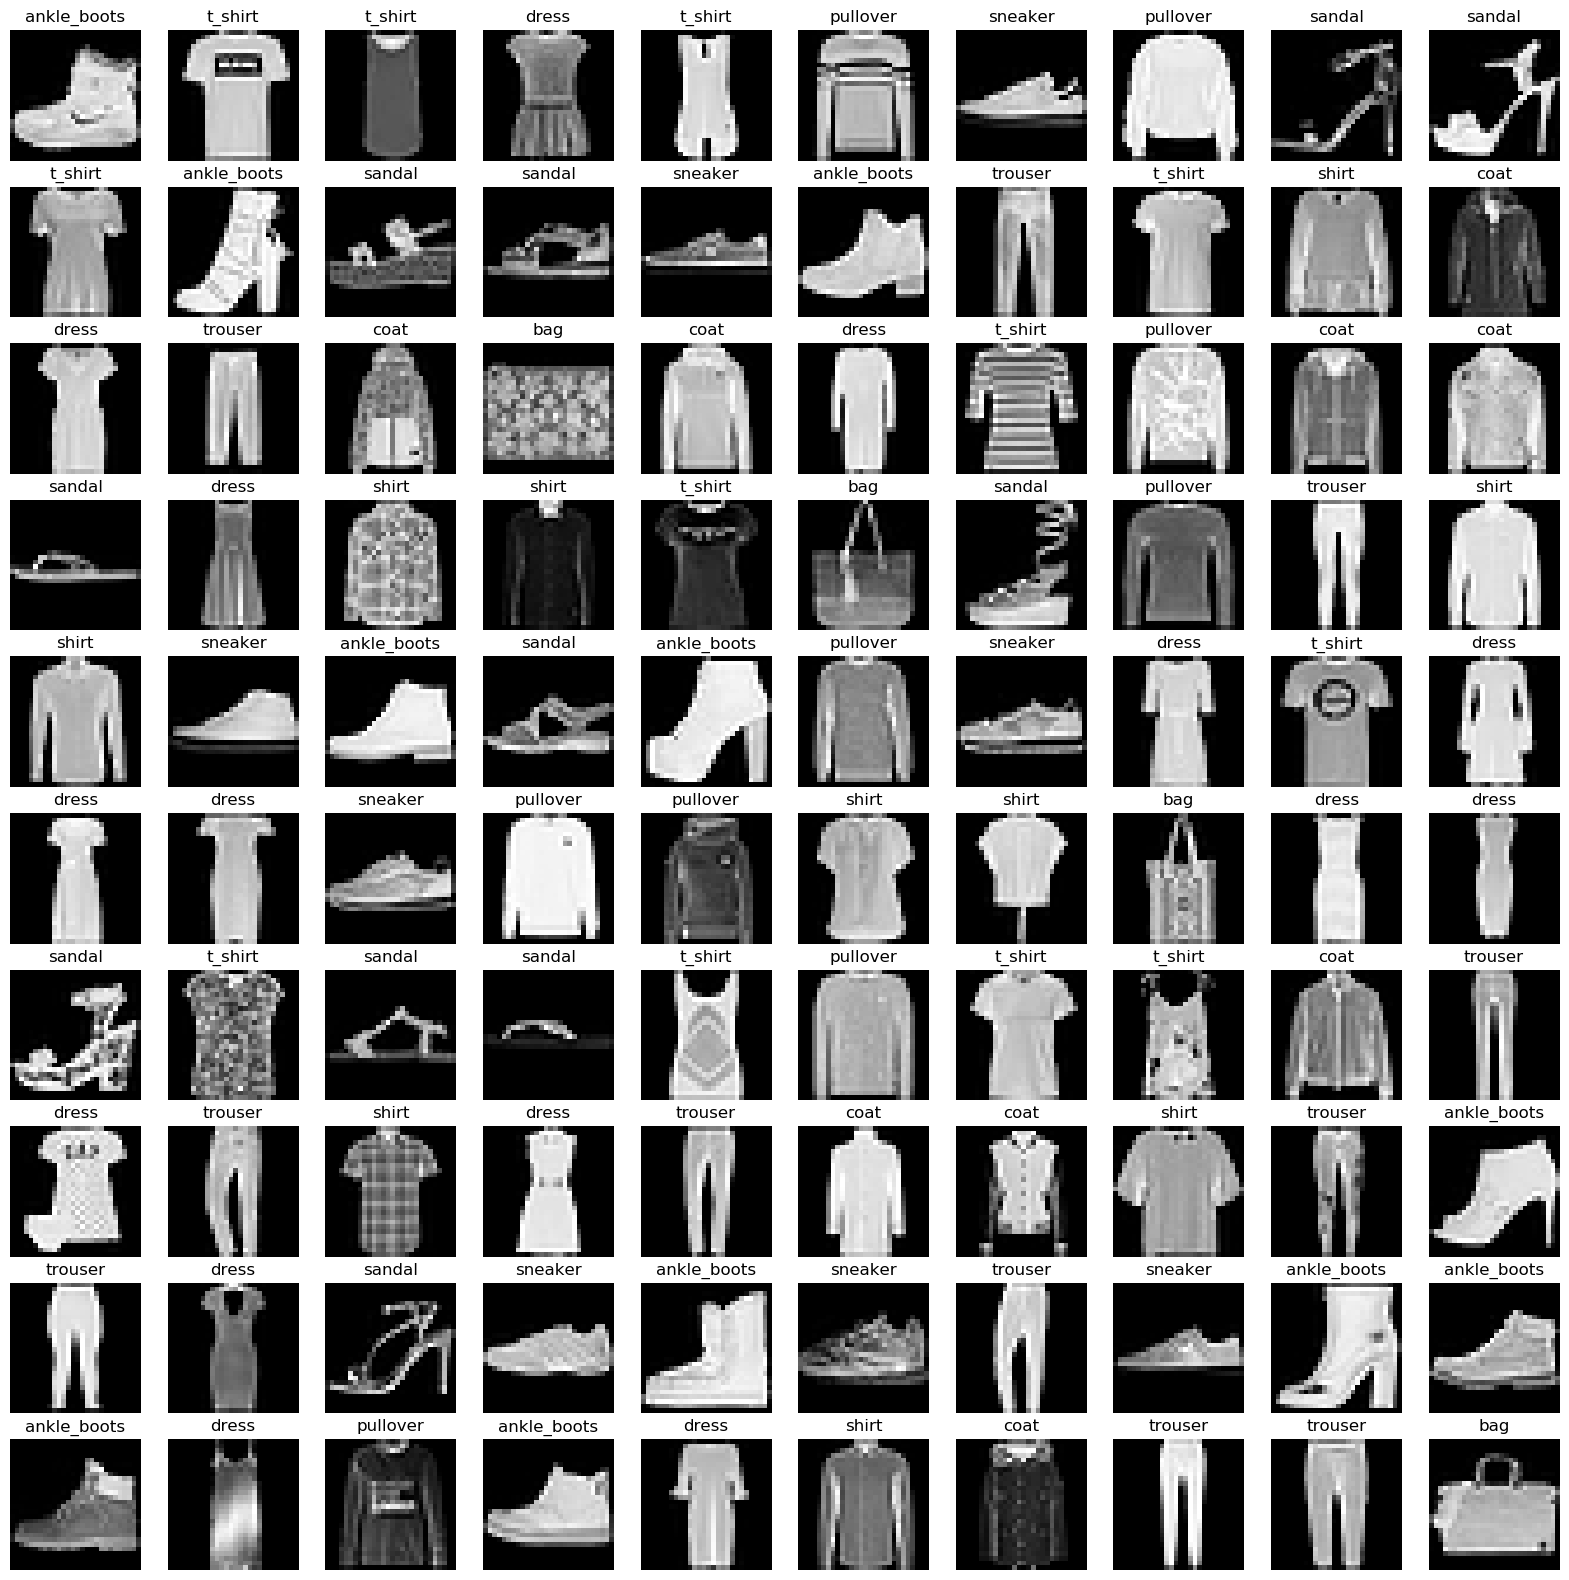

In [118]:
from jupyterthemes import jtplot
jtplot.reset()

plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(Xtrain[i, :].reshape(28, 28),cmap='gray')
    plt.title(labels[Ttrain[i, 0]])
    plt.axis('off');

In [174]:
n_hiddens_per_conv_layer = [10, 10, 5]
patch_size_per_conv_layer = [2, 2, 2]
stride_per_conv_layer=[1, 1, 1]
n_hiddens_per_fc_layer = [10]
n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet_fashion = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, activation_function='relu',device=device)



cnnet_fashion.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')

Classes, _ = cnnet_fashion.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
CM = confusion_matrix(Classes, Ttest)

adam: Epoch 2 Loss 0.395
adam: Epoch 4 Loss 0.329
adam: Epoch 6 Loss 0.298
adam: Epoch 8 Loss 0.285
adam: Epoch 10 Loss 0.269
adam: Epoch 12 Loss 0.257
adam: Epoch 14 Loss 0.251
adam: Epoch 16 Loss 0.242
adam: Epoch 18 Loss 0.232
adam: Epoch 20 Loss 0.230
Test accuracy in percent correct: 86.21


In [188]:

Classes, _ = cnnet_fashion.use(Xtrain)
Train_correct = 100 * np.mean(Classes == Ttrain)
print(f'Train accuracy in percent correct: {Train_correct:.2f}')
Classes, _ = cnnet_fashion.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
CM = confusion_matrix(Classes, Ttest)
CM.rename(columns={
    0: 't_shirt',
    1: 'trouser',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneaker',
    8: 'bag',
    9: 'ankle_boots'
},index={
    0: 't_shirt',
    1: 'trouser',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneaker',
    8: 'bag',
    9: 'ankle_boots'},
          inplace=True)
CM.style.background_gradient(cmap='Greens').format("{:.1f} %")

Train accuracy in percent correct: 91.02
Test accuracy in percent correct: 86.21


,t_shirt,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle_boots
t_shirt,81.7 %,0.4 %,3.0 %,1.7 %,0.8 %,0.4 %,10.9 %,0.0 %,1.1 %,0.0 %
trouser,0.3 %,95.8 %,0.3 %,2.1 %,0.8 %,0.1 %,0.3 %,0.0 %,0.3 %,0.0 %
pullover,1.7 %,0.2 %,81.9 %,0.5 %,8.5 %,0.3 %,6.6 %,0.0 %,0.3 %,0.0 %
dress,3.0 %,1.0 %,2.2 %,83.8 %,6.0 %,0.2 %,3.1 %,0.1 %,0.6 %,0.0 %
coat,0.2 %,0.2 %,9.6 %,2.6 %,81.5 %,0.0 %,5.8 %,0.0 %,0.1 %,0.0 %
sandal,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,94.5 %,0.0 %,3.9 %,0.3 %,1.3 %
shirt,12.4 %,0.1 %,8.1 %,3.6 %,12.0 %,0.2 %,61.7 %,0.0 %,1.9 %,0.0 %
sneaker,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,3.3 %,0.0 %,93.4 %,0.1 %,3.2 %
bag,0.4 %,0.2 %,0.7 %,0.3 %,0.8 %,0.8 %,1.6 %,0.3 %,94.9 %,0.0 %
ankle_boots,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %,1.7 %,0.0 %,5.3 %,0.1 %,92.9 %


Number of images with predicted probability less than 0.001: 86
The Following Images were poorly predicted


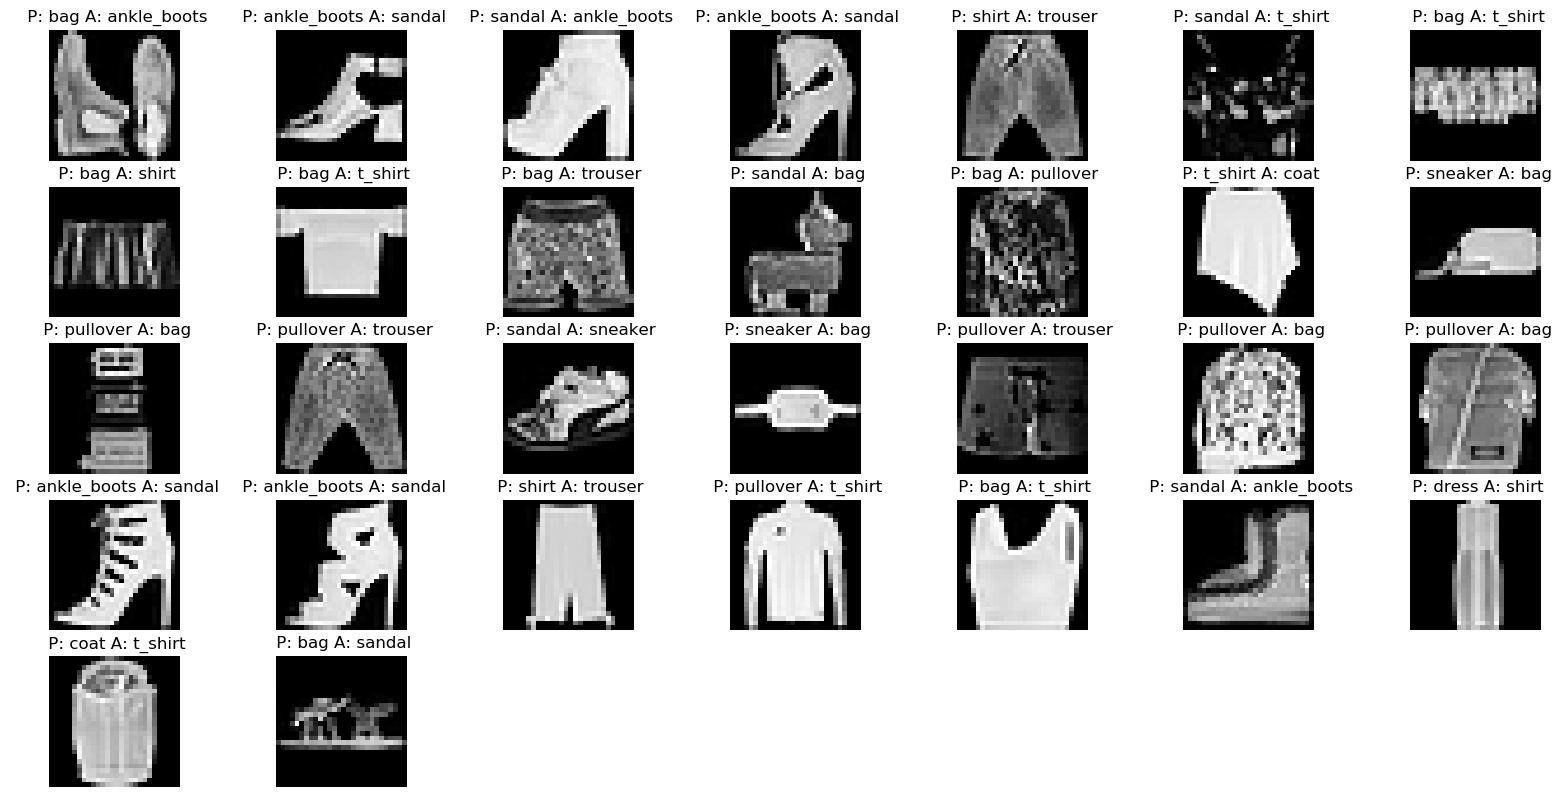

In [181]:
Y_classes1, Y_probs1 = cnnet_fashion.use(Xtest)
x=0.001
Cort_val = Y_probs1[range(10000), Ttest.reshape(-1)]
new_array = np.sort(Cort_val[Cort_val<x])
number = np.shape(new_array)[0]
print("Number of images with predicted probability less than %.3f" %x +": %d" %number)
print("The Following Images were poorly predicted")

plt.figure(figsize=(20, 20))
# 
for i in range(0,30):
    idx = np.where(Cort_val == new_array[i])
    idx = idx[0][0]
    # set_trace()
    plt.subplot(10, 7, i +1)
    plt.imshow(Xtest[idx,:].reshape(28,28),cmap = 'gray') 
    # plt.imshow(-Xtrain[i, :].reshape(28, 28), cmap='gray')
    plt.title(" P: %s " % labels[Y_classes1[idx,0]] + "A: %s"% labels[Ttest[idx,0]])
    plt.axis('off');
    

In [142]:
np.shape(T_Train)

(60000,)